2025-03-10 23:34:32 | INFO     | Starting main
2025-03-10 23:34:32 | INFO     | Starting load_all_forecast_data
2025-03-10 23:34:34 | INFO     | Loaded LASSO data: 126658 rows, 91 columns
2025-03-10 23:34:36 | INFO     | Loaded OLS data: 126658 rows, 91 columns
2025-03-10 23:34:38 | INFO     | Loaded RIDGE data: 126658 rows, 91 columns
2025-03-10 23:34:40 | INFO     | Loaded AR data: 126658 rows, 90 columns
2025-03-10 23:34:42 | INFO     | Loaded HVZ data: 126658 rows, 93 columns
2025-03-10 23:34:44 | INFO     | Loaded RI data: 126658 rows, 90 columns
2025-03-10 23:34:46 | INFO     | Loaded RW data: 126658 rows, 90 columns
2025-03-10 23:34:49 | INFO     | Loaded RF data: 126658 rows, 87 columns
2025-03-10 23:34:49 | WARNING  | File not found: results/gbr_forecasts.csv
2025-03-10 23:34:49 | INFO     | Loaded ANN data: 2 rows, 1 columns
2025-03-10 23:34:49 | WARNING  | Missing required columns for ann, skipping merge
2025-03-10 23:34:49 | INFO     | Created COMP_LR from 3 models
2025-03-


DATA QUALITY SUMMARY

EXRET12M (Return Data) Sources:
--------------------------------------------------
E_future: 126,658 values (100.0%)

ML Residual Sources by Model:
--------------------------------------------------

LASSO Residuals:
  orthogonalized: 126,658 values (100.0%)

OLS Residuals:
  orthogonalized: 126,658 values (100.0%)

RIDGE Residuals:
  orthogonalized: 126,658 values (100.0%)

RF Residuals:
  orthogonalized: 126,658 values (100.0%)

COMP_LR Residuals:
  orthogonalized: 126,658 values (100.0%)

COMP_NL Residuals:
  orthogonalized: 126,658 values (100.0%)

COMP_ML Residuals:
  orthogonalized: 126,658 values (100.0%)

Data Completeness:
--------------------------------------------------
EXRET12M: 126,658/126,658 non-missing values (100.0%)
SIZE: 126,658/126,658 non-missing values (100.0%)
BM: 126,658/126,658 non-missing values (100.0%)
MOM: 126,647/126,658 non-missing values (100.0%)
ROE: 126,658/126,658 non-missing values (100.0%)
INV: 125,320/126,658 non-missing val

2025-03-10 23:36:06 | INFO     | Created visualization: ml_model_comparison.png
2025-03-10 23:36:06 | INFO     | Completed main in 0:01:33.465531



Visualization saved to: ml_model_comparison.png


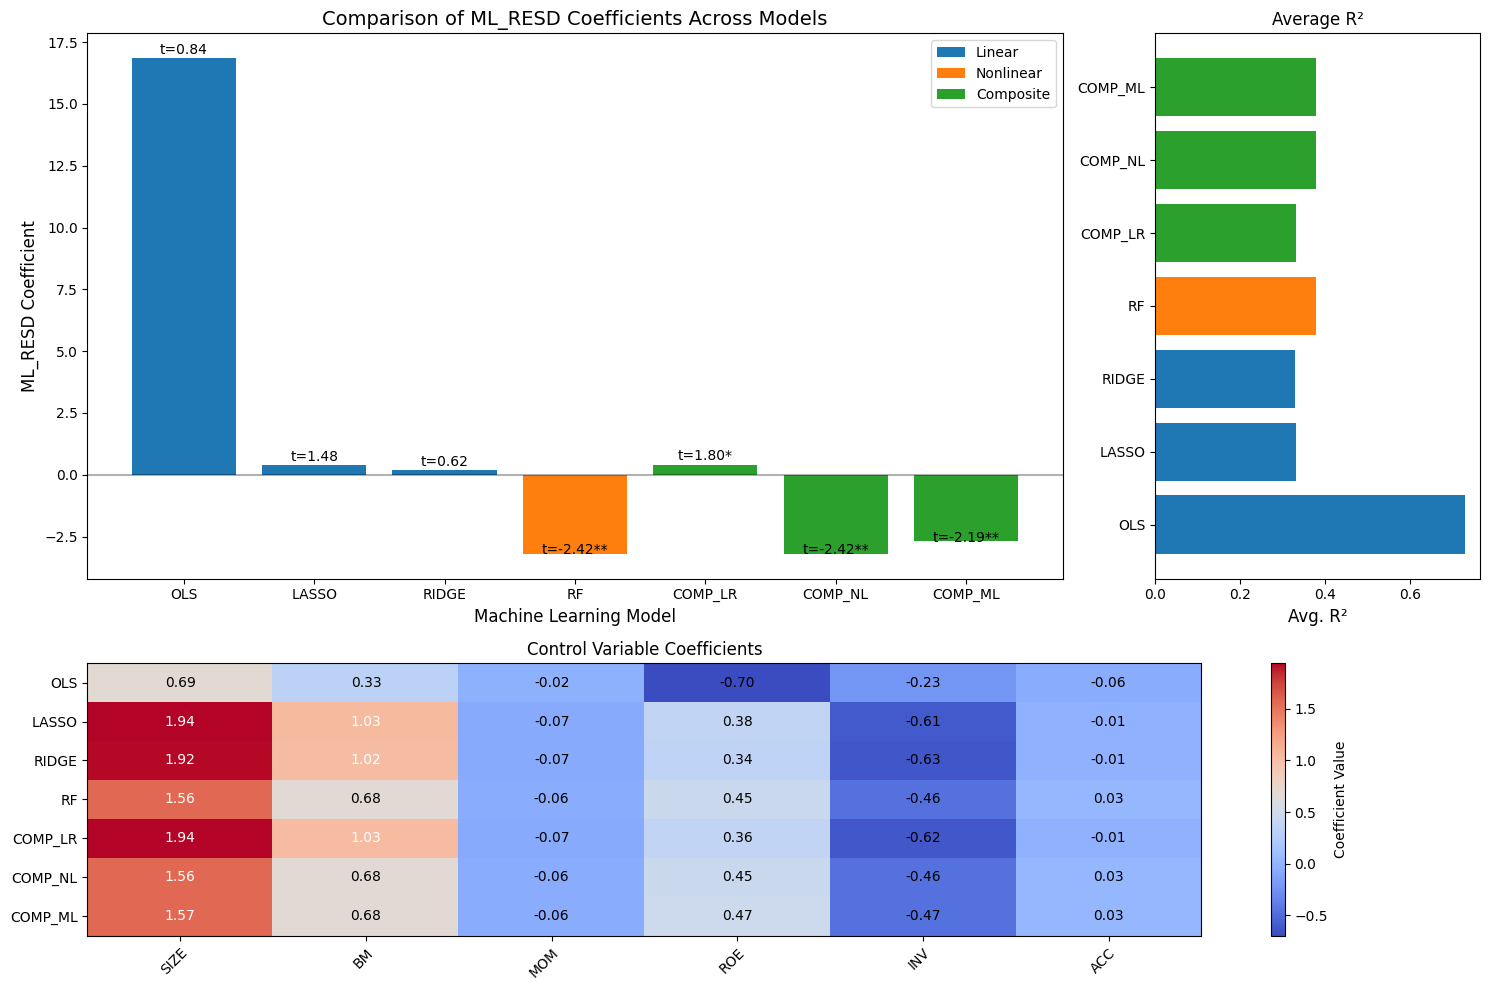

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import logging
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Configure minimalist logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)-8s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

def timer(func):
    """Decorator to time function execution."""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        logger.info(f"Starting {func.__name__}")
        result = func(*args, **kwargs)
        elapsed = time.time() - start_time
        logger.info(f"Completed {func.__name__} in {timedelta(seconds=elapsed)}")
        return result
    return wrapper

def winsorize_series(s, lower=0.01, upper=0.99, name=None):
    """Winsorize series at specified percentiles."""
    if s.isna().all() or len(s) == 0:
        return s
        
    s_valid = s.dropna()
    if len(s_valid) < 10:
        return s
        
    # Calculate quantiles and winsorize
    q_low = s_valid.quantile(lower)
    q_high = s_valid.quantile(upper)
    result = s.clip(q_low, q_high)
    return result

@timer
def load_all_forecast_data():
    """Load all forecast files."""
    # Define file paths
    file_paths = {
        'lasso': os.path.join("results", "lasso_forecasts.csv"),
        'ols': os.path.join("results", "ols_forecasts.csv"),
        'ridge': os.path.join("results", "ridge_forecasts.csv"),
        'ar': os.path.join("results", "ar_forecasts.csv"),
        'hvz': os.path.join("results", "hvz_forecasts.csv"),
        'ri': os.path.join("results", "ri_forecasts.csv"),
        'rw': os.path.join("results", "rw_forecasts.csv"),
        'rf': os.path.join("results", "rf_forecasts.csv"),
        'gbr': os.path.join("results", "gbr_forecasts.csv"),
        'ann': os.path.join("results", "ann_forecasts.csv")
    }
    
    # Load all files
    dataframes = {}
    merge_keys = ['gvkey', 'fyear', 'jdate']
    first_model = True
    
    for model, file_path in file_paths.items():
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                logger.info(f"Loaded {model.upper()} data: {df.shape[0]} rows, {df.shape[1]} columns")
                
                # Convert columns to appropriate types
                for col in ['gvkey', 'fyear', 'sic']:
                    if col in df.columns:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                
                # Convert date columns
                for col in ['datadate', 'jdate', 'date_x', 'date_y']:
                    if col in df.columns:
                        df[col] = pd.to_datetime(df[col], errors='coerce')
                
                # Extract E_pred column
                pred_col = f'E_pred_{model}'
                if pred_col not in df.columns and 'E_pred' in df.columns:
                    df[pred_col] = pd.to_numeric(df['E_pred'], errors='coerce')
                
                if first_model:
                    # For the first model, save the entire dataframe
                    merged_df = df.copy()
                    first_model = False
                else:
                    # For subsequent models, merge in only the prediction column
                    cols_to_keep = merge_keys + [pred_col]
                    if all(col in df.columns for col in cols_to_keep):
                        df_slim = df[cols_to_keep].copy()
                        merged_df = merged_df.merge(df_slim, on=merge_keys, how='outer')
                    else:
                        logger.warning(f"Missing required columns for {model}, skipping merge")
                
                dataframes[model] = df
            except Exception as e:
                logger.error(f"Error loading {file_path}: {str(e)}")
        else:
            logger.warning(f"File not found: {file_path}")
    
    # Ensure we have key numeric columns
    numeric_cols = [
        'mkt_cap', 'ceq', 'ib', 'at', 'oancf', 'retadj', 'rf', 'sic', 'fyear', 'gvkey',
        'E_future'
    ]
    
    # Add all E_pred columns to numeric columns
    for model in dataframes.keys():
        numeric_cols.append(f'E_pred_{model}')
    
    for col in numeric_cols:
        if col in merged_df.columns:
            merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    
    # Create composite models
    # 1. Composite Linear (COMP_LR): average of OLS, LASSO, Ridge
    linear_models = ['ols', 'lasso', 'ridge']
    linear_cols = [f'E_pred_{model}' for model in linear_models if f'E_pred_{model}' in merged_df.columns]
    if len(linear_cols) > 0:
        merged_df['E_pred_comp_lr'] = merged_df[linear_cols].mean(axis=1)
        logger.info(f"Created COMP_LR from {len(linear_cols)} models")
    
    # 2. Composite Nonlinear (COMP_NL): average of RF, GBR, ANN
    nonlinear_models = ['rf', 'gbr', 'ann']
    nonlinear_cols = [f'E_pred_{model}' for model in nonlinear_models if f'E_pred_{model}' in merged_df.columns]
    if len(nonlinear_cols) > 0:
        merged_df['E_pred_comp_nl'] = merged_df[nonlinear_cols].mean(axis=1)
        logger.info(f"Created COMP_NL from {len(nonlinear_cols)} models")
    
    # 3. Composite Machine Learning (COMP_ML): average of all ML models
    all_ml_cols = linear_cols + nonlinear_cols
    if len(all_ml_cols) > 0:
        merged_df['E_pred_comp_ml'] = merged_df[all_ml_cols].mean(axis=1)
        logger.info(f"Created COMP_ML from {len(all_ml_cols)} models")
    
    return merged_df

@timer
def calculate_actual_excess_returns(df):
    """Calculate actual 12-month forward excess returns."""
    # Initialize the EXRET12M column
    df['EXRET12M'] = np.nan
    df['EXRET12M_source'] = 'missing'
    
    # Use E_future as a source for excess returns
    if 'E_future' in df.columns:
        df['EXRET12M'] = df['E_future']
        df['EXRET12M_source'] = 'E_future'
        
        # If E_future is in percentage form (mean > 1), convert to decimal
        if abs(df['EXRET12M'].mean()) > 1.0:
            df['EXRET12M'] = df['EXRET12M'] * 0.01
            logger.info("Scaled EXRET12M to decimal form")
    
    # Winsorize the returns
    df['EXRET12M'] = winsorize_series(df['EXRET12M'], name='EXRET12M')
    
    return df

@timer
def orthogonalize_ml_forecasts(df, model_name):
    """Orthogonalize ML forecasts against benchmark models."""
    # Normalize model name to lowercase for column access
    ml_model = model_name.lower()
    
    # Define column name based on model
    if ml_model in ['comp_lr', 'comp_nl', 'comp_ml']:
        ml_col = f'E_pred_{ml_model}'
    else:
        ml_col = f'E_pred_{ml_model}'
    
    # Check if column exists
    if ml_col not in df.columns:
        logger.error(f"Model column {ml_col} not found")
        raise ValueError(f"Model column {ml_col} not found in data")
    
    # Define output column name for residuals
    resd_col = f'ML_RESD_{ml_model}'
    
    # Initialize residual column
    df[resd_col] = np.nan
    df[f'{resd_col}_source'] = 'missing'
    
    # Define benchmark models - based on the paper's methodology
    benchmark_models = ['rw', 'ols', 'ar', 'hvz', 'ri']
    
    # Ensure ML predictions are in decimal form
    if abs(df[ml_col].mean()) > 1.0:
        df[ml_col] = df[ml_col] * 0.01
    
    # Filter available benchmarks
    available_benchmarks = []
    for model in benchmark_models:
        bench_col = f'E_pred_{model}'
        if bench_col in df.columns:
            # Ensure benchmark predictions are in decimal form
            if abs(df[bench_col].mean()) > 1.0:
                df[bench_col] = df[bench_col] * 0.01
            available_benchmarks.append(model)
    
    if not available_benchmarks:
        logger.error(f"No benchmark models found for orthogonalization of {model_name}")
        return df
    
    # Get benchmark columns
    bench_cols = [f'E_pred_{model}' for model in available_benchmarks]
    
    # Process each year separately
    years = sorted(df['fyear'].dropna().unique())
    successful_years = 0
    
    for year in years:
        # Get data for this year
        year_data = df[df['fyear'] == year].copy()
        
        if len(year_data) < 10:  # Skip years with very few observations
            continue
        
        # Drop rows with missing values in any model
        valid_data = year_data.dropna(subset=[ml_col] + bench_cols)
        
        if len(valid_data) < 10:  # Need enough observations
            continue
        
        try:
            # Run regression of ML forecast on benchmark forecasts
            X = sm.add_constant(valid_data[bench_cols])
            y = valid_data[ml_col]
            
            model = sm.OLS(y, X).fit()
            
            # Extract residuals
            residuals = model.resid
            
            # Store the residuals
            df.loc[valid_data.index, resd_col] = residuals
            df.loc[valid_data.index, f'{resd_col}_source'] = 'orthogonalized'
            successful_years += 1
            
        except Exception as e:
            logger.error(f"Error orthogonalizing {model_name} for year {year}: {str(e)}")
    
    # Standardize ML_RESD
    if not df[resd_col].isna().all():
        # Record non-standardized stats
        pre_std_mean = df[resd_col].mean()
        pre_std_sd = df[resd_col].std()
        
        # Standardize
        df[resd_col] = (df[resd_col] - pre_std_mean) / pre_std_sd
    
    # Winsorize the residuals
    df[resd_col] = winsorize_series(df[resd_col])
    
    return df

@timer
def create_control_variables(df):
    """Create control variables for Fama-MacBeth regressions."""
    # Convert key columns to numeric
    numeric_cols = ['mkt_cap', 'ceq', 'ib', 'at', 'oancf', 'retadj', 'rf', 'sic']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # SIZE: log of market cap
    if 'mkt_cap' in df.columns and df['mkt_cap'].notna().sum() > 0:
        # Log-transform market cap
        df['SIZE'] = np.log(df['mkt_cap'].clip(lower=1e-8))
        df['SIZE'] = df['SIZE'].replace([np.inf, -np.inf], np.nan)
        
        # Interpolate if not too many missing values
        if df['SIZE'].isna().mean() <= 0.15:
            df['SIZE'] = df.groupby('gvkey')['SIZE'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
        
        # Standardize
        if df['SIZE'].notna().any() and df['SIZE'].std() > 0:
            size_mean = df['SIZE'].mean()
            size_std = df['SIZE'].std()
            df['SIZE'] = (df['SIZE'] - size_mean) / size_std
        
        # Winsorize
        df['SIZE'] = winsorize_series(df['SIZE'])
    
    # BM: book-to-market ratio
    if all(col in df.columns for col in ['ceq', 'mkt_cap']) and df['ceq'].notna().sum() > 0 and df['mkt_cap'].notna().sum() > 0:
        df['BM'] = df['ceq'] / df['mkt_cap'].clip(lower=1e-8)
        df['BM'] = df['BM'].replace([np.inf, -np.inf], np.nan)
        
        # Interpolate if not too many missing values
        if df['BM'].isna().mean() <= 0.15:
            df['BM'] = df.groupby('gvkey')['BM'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
        
        # Standardize
        if df['BM'].notna().any() and df['BM'].std() > 0:
            bm_mean = df['BM'].mean()
            bm_std = df['BM'].std()
            df['BM'] = (df['BM'] - bm_mean) / bm_std
        
        # Winsorize
        df['BM'] = winsorize_series(df['BM'])
    
    # ROE: return on equity
    if all(col in df.columns for col in ['ib', 'ceq']) and df['ib'].notna().sum() > 0 and df['ceq'].notna().sum() > 0:
        df['ROE'] = df['ib'] / df['ceq'].clip(lower=1e-8)
        df['ROE'] = df['ROE'].replace([np.inf, -np.inf], np.nan)
        
        # Handle extreme outliers
        if df['ROE'].notna().any():
            roe_mean = df['ROE'].mean()
            roe_std = df['ROE'].std()
            
            # If extreme values detected, apply more aggressive clipping
            if abs(roe_mean) > 100 or roe_std > 1000:
                q_low = df['ROE'].quantile(0.001)
                q_high = df['ROE'].quantile(0.999)
                df['ROE'] = df['ROE'].clip(q_low, q_high)
        
        # Interpolate if not too many missing values
        if df['ROE'].isna().mean() <= 0.15:
            df['ROE'] = df.groupby('gvkey')['ROE'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
        
        # Standardize
        if df['ROE'].notna().any() and df['ROE'].std() > 0:
            roe_mean = df['ROE'].mean()
            roe_std = df['ROE'].std()
            df['ROE'] = (df['ROE'] - roe_mean) / roe_std
        
        # Winsorize
        df['ROE'] = winsorize_series(df['ROE'])
    
    # INV: investment growth
    if 'at' in df.columns and df['at'].notna().sum() > 0:
        try:
            # Sort by firm and year
            df = df.sort_values(['gvkey', 'fyear'])
            
            # Calculate percent change in assets within each firm
            df['INV'] = df.groupby('gvkey')['at'].pct_change()
            df['INV'] = df['INV'].replace([np.inf, -np.inf], np.nan)
            
            # Interpolate if not too many missing values
            if df['INV'].isna().mean() <= 0.15:
                df['INV'] = df.groupby('gvkey')['INV'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
            
            # Standardize
            if df['INV'].notna().any() and df['INV'].std() > 0:
                inv_mean = df['INV'].mean()
                inv_std = df['INV'].std()
                df['INV'] = (df['INV'] - inv_mean) / inv_std
            
            # Winsorize
            df['INV'] = winsorize_series(df['INV'])
        except Exception as e:
            logger.error(f"Error creating INV: {str(e)}")
    
    # ACC: accruals
    if all(col in df.columns for col in ['ib', 'oancf', 'at']) and df['ib'].notna().sum() > 0 and df['oancf'].notna().sum() > 0 and df['at'].notna().sum() > 0:
        # Calculate ACC
        df['ACC'] = (df['ib'] - df['oancf']) / df['at'].clip(lower=1e-8)
        df['ACC'] = df['ACC'].replace([np.inf, -np.inf], np.nan)
        
        # Handle extreme outliers
        if df['ACC'].notna().any():
            acc_mean = df['ACC'].mean()
            acc_std = df['ACC'].std()
            
            if abs(acc_mean) > 100 or acc_std > 1000:
                q_low = df['ACC'].quantile(0.001)
                q_high = df['ACC'].quantile(0.999)
                df['ACC'] = df['ACC'].clip(q_low, q_high)
        
        # Interpolate if not too many missing values
        if df['ACC'].isna().mean() <= 0.15:
            df['ACC'] = df.groupby('gvkey')['ACC'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
        
        # Standardize
        if df['ACC'].notna().any() and df['ACC'].std() > 0:
            acc_mean = df['ACC'].mean()
            acc_std = df['ACC'].std()
            df['ACC'] = (df['ACC'] - acc_mean) / acc_std
        
        # Winsorize
        df['ACC'] = winsorize_series(df['ACC'])
    
    # MOM: momentum using retadj
    if 'retadj' in df.columns and df['retadj'].notna().sum() > 0:
        # Calculate MOM
        df['MOM'] = df['retadj']
        
        # Convert percentage to decimal if needed
        if df['MOM'].notna().any() and abs(df['MOM'].mean()) > 1.0:
            df['MOM'] = df['MOM'] * 0.01
        
        df['MOM'] = df['MOM'].replace([np.inf, -np.inf], np.nan)
        
        # Interpolate if not too many missing values
        if df['MOM'].isna().mean() <= 0.15:
            df['MOM'] = df.groupby('gvkey')['MOM'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
        
        # Standardize
        if df['MOM'].notna().any() and df['MOM'].std() > 0:
            mom_mean = df['MOM'].mean()
            mom_std = df['MOM'].std()
            df['MOM'] = (df['MOM'] - mom_mean) / mom_std
        
        # Winsorize
        df['MOM'] = winsorize_series(df['MOM'])
    
    # Create SIC3 for industry fixed effects
    if 'sic' in df.columns and df['sic'].notna().any():
        df['sic3'] = (df['sic'] // 10).astype(int)
    
    return df

@timer
def run_fama_macbeth_with_industry_fe(df, y_col, x_cols, time_col='fyear', ind_col='sic3', min_obs=10):
    """Run Fama-MacBeth regressions with industry fixed effects."""
    # Filter to valid observations only
    valid_obs = df.dropna(subset=[y_col] + x_cols)
    valid_pct = len(valid_obs) / len(df) * 100
    logger.info(f"Valid observations: {len(valid_obs)}/{len(df)} ({valid_pct:.1f}%)")
    
    # Check for variation in variables
    std_values = {}
    for col in [y_col] + x_cols:
        std_values[col] = valid_obs[col].std()
    
    # Filter to variables with non-zero standard deviation
    valid_x_cols = [col for col in x_cols if std_values[col] > 0]
    
    # Run cross-sectional regressions by year
    all_results = []
    r2_list = []
    years = sorted(valid_obs[time_col].unique())
    logger.info(f"Data spans {len(years)} years")
    
    # Initialize counters
    successful_years = 0
    failed_years = 0
    
    for yr in years:
        # Get data for this year
        year_data = valid_obs[valid_obs[time_col] == yr].copy()
        
        # Skip if too few observations
        if len(year_data) < min_obs:
            continue
        
        # Check for variation in this year's data
        year_std_values = {}
        for col in [y_col] + valid_x_cols:
            year_std_values[col] = year_data[col].std()
        
        # Filter to variables with non-zero standard deviation in this year
        year_valid_x_cols = [col for col in valid_x_cols if year_std_values[col] > 0]
        
        # Skip if no valid independent variables
        if not year_valid_x_cols:
            failed_years += 1
            continue
        
        try:
            # Add industry fixed effects if available and appropriate
            has_industry_fe = False
            if ind_col in year_data.columns and len(year_data[ind_col].unique()) > 1:
                # Need at least 2 industries for fixed effects
                ind_counts = year_data[ind_col].value_counts()
                multi_obs_industries = sum(ind_counts > 1)
                
                if multi_obs_industries >= 2:
                    # Get dummies, convert to float64
                    ind_dummies = pd.get_dummies(year_data[ind_col], prefix='ind', drop_first=True)
                    ind_dummies = ind_dummies.astype('float64')
                    
                    # Create X matrix with constant, main variables, and industry dummies
                    X_vars = year_data[year_valid_x_cols].astype('float64')
                    X_with_fe = pd.concat([X_vars, ind_dummies], axis=1)
                    X = sm.add_constant(X_with_fe)
                    has_industry_fe = True
                else:
                    # Just use main variables
                    X = sm.add_constant(year_data[year_valid_x_cols])
            else:
                # Just use main variables
                X = sm.add_constant(year_data[year_valid_x_cols])
            
            # Y variable
            y = year_data[y_col]
            
            # Run regression
            results = sm.OLS(y, X).fit()
            
            # Store coefficients for main variables
            year_result = {'year': yr}
            year_result['const'] = results.params['const']
            
            # For each main variable, store coefficient (or NaN if not used)
            for col in x_cols:
                if col in year_valid_x_cols:
                    year_result[col] = results.params[col]
                else:
                    year_result[col] = np.nan
            
            # Store R-squared and other metrics
            year_result['r2'] = results.rsquared
            year_result['adj_r2'] = results.rsquared_adj
            year_result['n_obs'] = len(year_data)
            year_result['has_industry_fe'] = has_industry_fe
            
            all_results.append(year_result)
            r2_list.append(results.rsquared_adj)
            successful_years += 1
            
            logger.info(f"Year {yr}: Regression successful, R² = {results.rsquared:.4f}")
            
        except Exception as e:
            logger.error(f"Year {yr}: Regression failed: {str(e)}")
            failed_years += 1
            continue
    
    # If no regressions ran successfully, we can't proceed
    if not all_results:
        logger.error("No cross-sectional regressions ran successfully")
        raise ValueError("No cross-sectional regressions ran successfully")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Calculate time-series statistics
    final_results = {}
    for col in ['const'] + x_cols:
        if col in results_df.columns:
            # Only use non-NaN values
            series = results_df[col].dropna()
            if len(series) > 0:
                mean_val = series.mean()
                if len(series) > 1:
                    std_val = series.std()
                    t_stat = mean_val / (std_val / np.sqrt(len(series)))
                else:
                    std_val = np.nan
                    t_stat = np.nan
                    
                final_results[col] = {
                    'coef': mean_val, 
                    't': t_stat,
                    'std': std_val,
                    'n_years': len(series)
                }
            else:
                final_results[col] = {
                    'coef': np.nan, 
                    't': np.nan,
                    'std': np.nan,
                    'n_years': 0
                }
    
    # Add R-squared and other summary stats
    final_results['avg_r2'] = np.mean(r2_list)
    final_results['n_years'] = len(all_results)
    final_results['successful_years'] = successful_years
    final_results['failed_years'] = failed_years
    final_results['pct_fe'] = results_df['has_industry_fe'].mean() * 100 if 'has_industry_fe' in results_df.columns else 0
    
    return final_results

def print_data_quality_summary(df, models):
    """Print a summary of data quality and sources."""
    print("\n" + "="*80)
    print("DATA QUALITY SUMMARY")
    print("="*80)
    
    # 1. EXRET12M sources
    if 'EXRET12M_source' in df.columns:
        print("\nEXRET12M (Return Data) Sources:")
        print("-" * 50)
        source_counts = df['EXRET12M_source'].value_counts()
        for source, count in source_counts.items():
            print(f"{source}: {count:,} values ({count/len(df):.1%})")
    
    # 2. ML_RESD sources for each model
    print("\nML Residual Sources by Model:")
    print("-" * 50)
    for model in models:
        model_lower = model.lower()
        resd_col = f'ML_RESD_{model_lower}_source'
        if resd_col in df.columns:
            print(f"\n{model.upper()} Residuals:")
            source_counts = df[resd_col].value_counts()
            for source, count in source_counts.items():
                print(f"  {source}: {count:,} values ({count/len(df):.1%})")
    
    # 3. Data completeness
    key_vars = ['EXRET12M', 'SIZE', 'BM', 'MOM', 'ROE', 'INV', 'ACC']
    # Add ML_RESD variables for each model
    for model in models:
        model_lower = model.lower()
        key_vars.append(f'ML_RESD_{model_lower}')
    
    print("\nData Completeness:")
    print("-" * 50)
    for var in key_vars:
        if var in df.columns:
            non_na = df[var].notna().sum()
            print(f"{var}: {non_na:,}/{len(df):,} non-missing values ({non_na/len(df):.1%})")
    
    # 4. Complete cases by model
    print("\nComplete Cases by Model:")
    print("-" * 50)
    for model in models:
        model_lower = model.lower()
        resd_col = f'ML_RESD_{model_lower}'
        if resd_col in df.columns:
            model_vars = ['EXRET12M', resd_col, 'SIZE', 'BM', 'MOM', 'ROE', 'INV', 'ACC']
            complete_count = df[model_vars].dropna().shape[0]
            print(f"{model.upper()}: {complete_count:,}/{len(df):,} complete cases ({complete_count/len(df):.1%})")
    
    # 5. Variable quality checks
    print("\nVariable Quality Checks:")
    print("-" * 50)
    for var in ['EXRET12M', 'SIZE', 'BM', 'MOM', 'ROE', 'INV', 'ACC']:
        if var in df.columns:
            # Calculate basic statistics
            mean_val = df[var].mean()
            std_val = df[var].std()
            min_val = df[var].min()
            max_val = df[var].max()
            
            print(f"{var}: Mean={mean_val:.4f}, Std={std_val:.4f}, Min={min_val:.4f}, Max={max_val:.4f}")
    
    print("\n" + "="*80 + "\n")

def create_table6(all_results):
    """Create Table 6 in the format of the paper."""
    # Define the models and categories in the correct order
    linear_models = ['OLS', 'LASSO', 'RIDGE']
    nonlinear_models = ['RF', 'GBR', 'ANN']
    composite_models = ['COMP_LR', 'COMP_NL', 'COMP_ML']
    
    # Available models in the results
    available_models = list(all_results.keys())
    
    # Function to add significance stars
    def add_stars(t_stat):
        if abs(t_stat) > 2.58:  # 1% significance
            return "***"
        elif abs(t_stat) > 1.96:  # 5% significance
            return "**"
        elif abs(t_stat) > 1.65:  # 10% significance
            return "*"
        return ""
    
    # Format Table 6 header
    table = "\n" + "="*100 + "\n"
    table += "Table 6: Regression analysis of future excess stock returns on the new information\n"
    table += "         uncovered using the machine learning models.\n"
    table += "="*100 + "\n"
    table += "Multivariate regression: EXRET12M = β₀ + β₁ML_RESD + β₂SIZE + β₃BM + β₄MOM + β₅ROE + β₆INV + β₇ACC + IndustryFE + ε.\n"
    table += "="*100 + "\n"
    table += f"{'':10s}{'β₀':>10s}{'β₁':>10s}{'β₂':>10s}{'β₃':>10s}{'β₄':>10s}{'β₅':>10s}{'β₆':>10s}{'β₇':>10s}{'Avg. R²':>10s}\n"
    table += f"{'':10s}{'':>10s}{'ML_RESD':>10s}{'SIZE':>10s}{'BM':>10s}{'MOM':>10s}{'ROE':>10s}{'INV':>10s}{'ACC':>10s}{'':>10s}\n"
    table += "-"*100 + "\n"
    
    # Linear models section
    if any(model in available_models for model in linear_models):
        table += "Linear machine learning models\n"
        for model in linear_models:
            if model in available_models:
                results = all_results[model]
                table += f"{model:10s}"
                
                # Add coefficients
                for param in ['const', 'ML_RESD', 'SIZE', 'BM', 'MOM', 'ROE', 'INV', 'ACC']:
                    if param in results and not np.isnan(results[param]['coef']):
                        table += f"{results[param]['coef']:>10.3f}"
                    else:
                        table += f"{'N/A':>10s}"
                
                # Add R-squared
                table += f"{results.get('avg_r2', np.nan):>10.2f}\n"
                
                # Add t-statistics row
                table += f"{'':10s}"
                for param in ['const', 'ML_RESD', 'SIZE', 'BM', 'MOM', 'ROE', 'INV', 'ACC']:
                    if param in results and not np.isnan(results[param]['t']):
                        table += f"({results[param]['t']:>8.2f})"
                    else:
                        table += f"{'(N/A)':>10s}"
                table += "\n"
        
    # Nonlinear models section
    if any(model in available_models for model in nonlinear_models):
        table += "Nonlinear machine learning models\n"
        for model in nonlinear_models:
            if model in available_models:
                results = all_results[model]
                table += f"{model:10s}"
                
                # Add coefficients
                for param in ['const', 'ML_RESD', 'SIZE', 'BM', 'MOM', 'ROE', 'INV', 'ACC']:
                    if param in results and not np.isnan(results[param]['coef']):
                        table += f"{results[param]['coef']:>10.3f}"
                    else:
                        table += f"{'N/A':>10s}"
                
                # Add R-squared
                table += f"{results.get('avg_r2', np.nan):>10.2f}\n"
                
                # Add t-statistics row
                table += f"{'':10s}"
                for param in ['const', 'ML_RESD', 'SIZE', 'BM', 'MOM', 'ROE', 'INV', 'ACC']:
                    if param in results and not np.isnan(results[param]['t']):
                        table += f"({results[param]['t']:>8.2f})"
                    else:
                        table += f"{'(N/A)':>10s}"
                table += "\n"
    
    # Composite models section
    if any(model in available_models for model in composite_models):
        table += "Composite models\n"
        for model in composite_models:
            if model in available_models:
                results = all_results[model]
                table += f"{model:10s}"
                
                # Add coefficients
                for param in ['const', 'ML_RESD', 'SIZE', 'BM', 'MOM', 'ROE', 'INV', 'ACC']:
                    if param in results and not np.isnan(results[param]['coef']):
                        table += f"{results[param]['coef']:>10.3f}"
                    else:
                        table += f"{'N/A':>10s}"
                
                # Add R-squared
                table += f"{results.get('avg_r2', np.nan):>10.2f}\n"
                
                # Add t-statistics row
                table += f"{'':10s}"
                for param in ['const', 'ML_RESD', 'SIZE', 'BM', 'MOM', 'ROE', 'INV', 'ACC']:
                    if param in results and not np.isnan(results[param]['t']):
                        table += f"({results[param]['t']:>8.2f})"
                    else:
                        table += f"{'(N/A)':>10s}"
                table += "\n"
    
    table += "="*100 + "\n"
    
    # Add additional notes
    table += "\nNotes: \n"
    table += "1. This table reports Fama-MacBeth regression results of one-year ahead excess returns on the new information\n"
    table += "   uncovered by machine learning models (ML_RESD), controlling for known return predictors.\n"
    table += "2. t-statistics are shown in parentheses below the coefficients.\n"
    table += "3. All variables are winsorized at 1% and 99% each year.\n"
    table += "4. Industry fixed effects (3-digit SIC) are included in all regressions.\n"
    
    return table

def create_visualization(all_results):
    """Create a visualization comparing ML_RESD coefficients across models."""
    # Get available models
    available_models = list(all_results.keys())
    
    # Prepare data for plotting
    coefs = []
    t_stats = []
    labels = []
    r2_values = []
    model_types = []
    
    # Categories
    linear_models = ['OLS', 'LASSO', 'RIDGE']
    nonlinear_models = ['RF', 'GBR', 'ANN']
    composite_models = ['COMP_LR', 'COMP_NL', 'COMP_ML']
    
    # Collect data in order
    for category, models in [("Linear", linear_models), 
                            ("Nonlinear", nonlinear_models), 
                            ("Composite", composite_models)]:
        for model in models:
            if model in available_models:
                results = all_results[model]
                if 'ML_RESD' in results and not np.isnan(results['ML_RESD']['coef']):
                    coefs.append(results['ML_RESD']['coef'])
                    t_stats.append(results['ML_RESD']['t'])
                    labels.append(model)
                    r2_values.append(results.get('avg_r2', 0))
                    model_types.append(category)
    
    # Check if we have data to plot
    if not coefs:
        return None
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    
    # Set up a nice color scheme
    colors = {'Linear': '#1f77b4', 'Nonlinear': '#ff7f0e', 'Composite': '#2ca02c'}
    
    # Create GridSpec for complex layout
    gs = GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[3, 1])
    
    # Main plot: Coefficient values with t-statistics
    ax1 = plt.subplot(gs[0, 0])
    
    # Compute significance indicators
    sig_markers = []
    for t in t_stats:
        if abs(t) > 2.58:  # 1% significance
            sig_markers.append('***')
        elif abs(t) > 1.96:  # 5% significance
            sig_markers.append('**')
        elif abs(t) > 1.65:  # 10% significance
            sig_markers.append('*')
        else:
            sig_markers.append('')
    
    # Create bars with custom colors
    bars = ax1.bar(labels, coefs, color=[colors[t] for t in model_types])
    
    # Add t-statistics and significance markers as text
    for i, (bar, t, marker) in enumerate(zip(bars, t_stats, sig_markers)):
        height = bar.get_height()
        if height > 0:
            y_pos = height + 0.05
        else:
            y_pos = height - 0.15
        ax1.text(bar.get_x() + bar.get_width()/2., y_pos,
                f't={t:.2f}{marker}', ha='center', va='bottom', fontsize=10)
    
    # Add a horizontal line at zero
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Labels and title
    ax1.set_xlabel('Machine Learning Model', fontsize=12)
    ax1.set_ylabel('ML_RESD Coefficient', fontsize=12)
    ax1.set_title('Comparison of ML_RESD Coefficients Across Models', fontsize=14)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[cat], label=cat) for cat in ['Linear', 'Nonlinear', 'Composite'] if cat in model_types]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # Add R-squared subplot
    ax2 = plt.subplot(gs[0, 1])
    ax2.barh(labels, r2_values, color=[colors[t] for t in model_types])
    ax2.set_xlabel('Avg. R²', fontsize=12)
    ax2.set_title('Average R²', fontsize=12)
    
    # Add coefficient heatmap
    ax3 = plt.subplot(gs[1, :])
    
    # Collect coefficient data for all variables
    var_names = ['SIZE', 'BM', 'MOM', 'ROE', 'INV', 'ACC']
    coef_data = []
    
    for model in labels:
        model_coefs = []
        for var in var_names:
            if var in all_results[model] and not np.isnan(all_results[model][var]['coef']):
                model_coefs.append(all_results[model][var]['coef'])
            else:
                model_coefs.append(np.nan)
        coef_data.append(model_coefs)
    
    # Create coefficient matrix
    coef_matrix = np.array(coef_data)
    
    # Create heatmap
    im = ax3.imshow(coef_matrix, cmap='coolwarm', aspect='auto')
    
    # Add colorbar
    plt.colorbar(im, ax=ax3, label='Coefficient Value')
    
    # Add labels
    ax3.set_xticks(np.arange(len(var_names)))
    ax3.set_yticks(np.arange(len(labels)))
    ax3.set_xticklabels(var_names)
    ax3.set_yticklabels(labels)
    
    # Rotate x labels
    plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add values to cells
    for i in range(len(labels)):
        for j in range(len(var_names)):
            if not np.isnan(coef_matrix[i, j]):
                ax3.text(j, i, f"{coef_matrix[i, j]:.2f}",
                        ha="center", va="center", color="white" if abs(coef_matrix[i, j]) > 1 else "black")
            else:
                ax3.text(j, i, "N/A", ha="center", va="center", color="black")
    
    ax3.set_title("Control Variable Coefficients", fontsize=12)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('ml_model_comparison.png', dpi=300, bbox_inches='tight')
    
    return 'ml_model_comparison.png'

@timer
def main():
    """Main execution function analyzing multiple machine learning models."""
    try:
        # 1. Load all forecast data
        df_merged = load_all_forecast_data()
        
        # 2. Calculate actual excess returns
        df_merged = calculate_actual_excess_returns(df_merged)
        
        # 3. Define the models to analyze
        model_list = ['lasso', 'ols', 'ridge', 'rf', 'gbr', 'ann', 'comp_lr', 'comp_nl', 'comp_ml']
        
        # Filter to models that have data
        available_models = []
        for model in model_list:
            pred_col = f'E_pred_{model}'
            if pred_col in df_merged.columns:
                available_models.append(model)
        
        logger.info(f"Available models: {', '.join(available_models)}")
        
        # 4. Create control variables
        df_merged = create_control_variables(df_merged)
        
        # 5. Create a dictionary to store results for all models
        all_results = {}
        
        # 6. Process each model
        for model_name in available_models:
            logger.info(f"Processing {model_name.upper()} model")
            
            try:
                # 6a. Orthogonalize ML forecasts for this model
                df_merged = orthogonalize_ml_forecasts(df_merged, model_name)
                
                # 6b. Run Fama-MacBeth regression
                control_vars = ['SIZE', 'BM', 'MOM', 'ROE', 'INV', 'ACC']
                
                # Column name for this model's residuals
                resd_col = f'ML_RESD_{model_name.lower()}'
                
                # All variables used in regression
                x_cols = [resd_col] + [var for var in control_vars if var in df_merged.columns]
                
                try:
                    results = run_fama_macbeth_with_industry_fe(
                        df_merged,
                        y_col='EXRET12M',
                        x_cols=x_cols,
                        time_col='fyear',
                        ind_col='sic3',
                        min_obs=10
                    )
                    
                    # 6c. Rename ML_RESD column in results for unified reporting
                    if resd_col in results:
                        results['ML_RESD'] = results[resd_col]
                        del results[resd_col]
                    
                    # 6d. Store results
                    all_results[model_name.upper()] = results
                    
                except Exception as e:
                    logger.error(f"Regression failed for {model_name}: {str(e)}")
            
            except Exception as e:
                logger.error(f"Orthogonalization failed for {model_name}: {str(e)}")
        
        # 7. Print data quality summary
        print_data_quality_summary(df_merged, [m.upper() for m in available_models])
        
        # 8. Generate Table 6
        if all_results:
            table6 = create_table6(all_results)
            print(table6)
            
            # Save Table 6 to file
            with open('table6_results.txt', 'w') as f:
                f.write(table6)
            
            # 9. Create visualization
            viz_filename = create_visualization(all_results)
            if viz_filename:
                logger.info(f"Created visualization: {viz_filename}")
                print(f"\nVisualization saved to: {viz_filename}")
        else:
            logger.error("No valid results to generate Table 6")
        
    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}", exc_info=True)
        raise

if __name__ == "__main__":
    main()